# EcoHome Energy Advisor - Agent Run & Evaluation

In this notebook, you'll run the Energy Advisor agent with various real-world scenarios and see how it helps customers optimize their energy usage.

## Learning Objectives
- Create the agent's instructions
- Run the Energy Advisor with different types of questions
- Evaluate response quality and accuracy
- Measure tool usage effectiveness
- Identify areas for improvement
- Implement evaluation metrics

## Evaluation Criteria
- **Accuracy**: Correct information and calculations
- **Relevance**: Responses address the user's question
- **Completeness**: Comprehensive answers with actionable advice
- **Tool Usage**: Appropriate use of available tools
- **Reasoning**: Clear explanation of recommendations


## 1. Import and Initialize

In [1]:
import json
import os
from datetime import datetime

from agent import Agent
from openai import OpenAI

In [2]:
ECOHOME_SYSTEM_PROMPT = """You are EcoHome Energy Advisor, an AI energy optimization specialist for smart homes. Your mission is to help homeowners reduce electricity costs and environmental impact through data-driven, personalized recommendations.

## Your Capabilities
- **Weather Analysis**: Retrieve and analyze weather forecasts to predict solar generation and plan energy usage around weather patterns.
- **Dynamic Pricing Optimization**: Access real-time time-of-use electricity pricing to recommend the cheapest hours for running devices.
- **Historical Usage Analysis**: Query past energy consumption data by device type, date range, and patterns to identify optimization opportunities.
- **Solar Generation Insights**: Analyze solar panel production data and correlate with weather conditions to maximize self-consumption.
- **Knowledge Base Search**: Search a curated database of energy-saving tips, best practices, and device-specific optimization strategies.
- **Savings Calculations**: Compute exact dollar and kWh savings from proposed optimizations with annual projections.

## Step-by-Step Workflow
For each user question, follow this process:
1. **Understand the Question**: Identify what the user needs — scheduling advice, cost analysis, device optimization, or general tips.
2. **Gather Data**: Use the appropriate tools to collect weather forecasts, electricity prices, historical usage, and solar generation data.
3. **Analyze Patterns**: Cross-reference pricing windows with weather/solar forecasts and historical usage patterns.
4. **Search Knowledge Base**: Find relevant energy-saving tips and best practices that apply to the user's situation.
5. **Calculate Savings**: When possible, quantify the financial benefit of your recommendations using the savings calculator.
6. **Provide Actionable Recommendations**: Give specific, time-based advice with dollar amounts and kWh savings.

## Response Format
Always structure your recommendations with:
- **Specific time windows** (e.g., "Charge your EV between 11 PM and 5 AM")
- **Dollar amounts** (e.g., "This saves approximately $0.17 per kWh compared to peak rates")
- **kWh estimates** when applicable
- **Alternative options** if the primary recommendation isn't feasible
- **Reasoning** explaining why each recommendation is optimal

## Example Questions You Handle
- "When should I charge my electric car tomorrow to minimize cost and maximize solar power?"
- "What temperature should I set my thermostat on Wednesday afternoon if electricity prices spike?"
- "How much can I save by running my dishwasher during off-peak hours instead of peak hours?"
- "Suggest three ways I can reduce energy use based on my usage history."
- "How can I maximize my solar panel usage this week given the weather forecast?"
- "Plan my energy usage for the weekend to minimize costs."
- "How should I manage my battery storage system with today's forecast?"

## Constraints
- Always cite data from the tools you've used (weather data, pricing data, usage history).
- Provide numerical estimates whenever possible — avoid vague advice like "save energy."
- Be specific about timing — say "between 10 AM and 2 PM" instead of "during the day."
- When solar data is relevant, factor in weather conditions and their impact on generation.
- Consider both immediate savings and long-term optimization strategies.
"""

In [3]:
ecohome_agent = Agent(
    instructions=ECOHOME_SYSTEM_PROMPT,
)

In [4]:
response = ecohome_agent.invoke(
    question="When should I charge my electric car tomorrow to minimize cost and maximize solar power?",
    context="Location: San Francisco, CA",
)

In [5]:
print(response["messages"][-1].content)

To minimize costs and maximize solar power when charging your electric vehicle (EV) tomorrow in San Francisco, here are the optimal charging times based on the weather forecast and electricity pricing:

### Optimal Charging Window
- **Charge your EV between 10 AM and 4 PM.**

### Reasoning
1. **Solar Generation**: 
   - The solar irradiance is expected to peak between **11 AM and 2 PM**, with the highest production at **1 PM** (approximately 684.9 W/m²). This means your solar panels will generate the most energy during this time, allowing you to utilize solar power for charging.
   
2. **Electricity Pricing**:
   - The electricity rates are as follows:
     - **10 AM - 4 PM**: $0.12 per kWh (mid-peak)
     - **4 PM - 9 PM**: $0.25 per kWh (peak)
   - Charging during the mid-peak hours (10 AM - 4 PM) is significantly cheaper than the peak hours (4 PM - 9 PM).

### Summary of Savings
- **Cost Comparison**:
  - Charging during mid-peak hours (10 AM - 4 PM) costs **$0.12 per kWh**.
  - If 

In [6]:
print("TOOLS:")
for msg in response["messages"]:
    obj = msg.model_dump()
    if obj.get("tool_call_id"):
        print("-", msg.name)

TOOLS:
- get_weather_forecast
- get_electricity_prices


## 2. Define Test Cases

In [7]:
# Comprehensive test cases covering different energy optimization scenarios
# Each test case includes an ID, question, expected tools, and expected response criteria

In [8]:
test_cases = [
    {
        "id": "ev_charging_1",
        "question": "When should I charge my electric car tomorrow to minimize cost and maximize solar power?",
        "expected_tools": ["get_weather_forecast", "get_electricity_prices"],
        "expected_response": "The response should contain specific time recommendation for EV charging, cost analysis comparing peak vs off-peak rates, and consideration of solar generation windows.",
    },
    {
        "id": "thermostat_1",
        "question": "What temperature should I set my thermostat on Wednesday afternoon if electricity prices spike during peak hours?",
        "expected_tools": ["get_electricity_prices", "search_energy_tips"],
        "expected_response": "The response should recommend specific thermostat temperatures during peak vs off-peak hours, reference pricing data, and include energy-saving thermostat tips.",
    },
    {
        "id": "appliance_schedule_1",
        "question": "When is the best time to run my dishwasher today based on electricity prices and weather?",
        "expected_tools": ["get_electricity_prices", "get_weather_forecast"],
        "expected_response": "The response should recommend specific hours for running the dishwasher, compare costs at different times, and consider solar generation availability.",
    },
    {
        "id": "solar_max_1",
        "question": "How can I maximize my solar panel usage this week given the weather forecast?",
        "expected_tools": ["get_weather_forecast", "query_solar_generation"],
        "expected_response": "The response should analyze the weather forecast for solar irradiance, reference historical solar generation data, and recommend shifting loads to peak solar hours.",
    },
    {
        "id": "cost_savings_1",
        "question": "How much money can I save by running my dishwasher during off-peak hours instead of peak hours?",
        "expected_tools": ["get_electricity_prices", "calculate_energy_savings"],
        "expected_response": "The response should include specific dollar savings per cycle and annually, compare peak vs off-peak rates, and quantify the kWh difference.",
    },
    {
        "id": "usage_history_1",
        "question": "Suggest three ways to reduce my energy consumption based on my usage history from the past two weeks.",
        "expected_tools": ["query_energy_usage", "search_energy_tips"],
        "expected_response": "The response should analyze historical usage data, identify the highest-consuming devices, and provide three specific actionable recommendations.",
    },
    {
        "id": "pool_pump_1",
        "question": "What is the best time to run my pool pump this week considering weather and electricity prices?",
        "expected_tools": ["get_weather_forecast", "get_electricity_prices"],
        "expected_response": "The response should recommend specific daily time windows for pool pump operation, factor in solar availability, and consider off-peak pricing.",
    },
    {
        "id": "ev_solar_1",
        "question": "Should I charge my EV from solar panels or grid power today? Which is more cost-effective?",
        "expected_tools": [
            "get_weather_forecast",
            "query_solar_generation",
            "get_electricity_prices",
        ],
        "expected_response": "The response should compare solar charging vs grid charging costs, analyze today's solar forecast, and recommend the optimal charging strategy.",
    },
    {
        "id": "hvac_optimize_1",
        "question": "How can I optimize my HVAC system for the current season to reduce energy bills?",
        "expected_tools": [
            "query_energy_usage",
            "search_energy_tips",
            "get_weather_forecast",
        ],
        "expected_response": "The response should include seasonal HVAC settings, reference current weather conditions, analyze HVAC usage patterns, and provide specific temperature recommendations.",
    },
    {
        "id": "overall_savings_1",
        "question": "What is my total potential monthly savings if I optimize all my devices to run during off-peak hours?",
        "expected_tools": [
            "query_energy_usage",
            "get_electricity_prices",
            "calculate_energy_savings",
        ],
        "expected_response": "The response should calculate total monthly savings across all device types, compare current vs optimized costs, and provide a device-by-device breakdown.",
    },
    {
        "id": "weekend_plan_1",
        "question": "Plan my energy usage for this weekend to minimize costs. I need to do laundry, run the dishwasher, and charge my EV.",
        "expected_tools": [
            "get_weather_forecast",
            "get_electricity_prices",
            "query_energy_usage",
        ],
        "expected_response": "The response should provide a weekend schedule with specific times for each device, factor in pricing and solar availability, and estimate total weekend energy costs.",
    },
    {
        "id": "solar_storage_1",
        "question": "How should I manage my battery energy storage system with today's weather forecast to maximize savings?",
        "expected_tools": [
            "get_weather_forecast",
            "query_solar_generation",
            "search_energy_tips",
        ],
        "expected_response": "The response should recommend charge/discharge times for the battery, factor in solar forecast, reference peak pricing windows, and include storage optimization tips.",
    },
]

print(f"Total test cases: {len(test_cases)}")
if len(test_cases) < 10:
    raise ValueError("You MUST have at least 10 test cases")

Total test cases: 12


## 3. Run Agent Tests

In [9]:
CONTEXT = "Location: San Francisco, CA"

In [10]:
# Run all agent tests and collect responses
print("=== Running Agent Tests ===")
test_results = []

for i, test_case in enumerate(test_cases):
    print(f"\nTest {i + 1}/{len(test_cases)}: {test_case['id']}")
    print(f"Question: {test_case['question'][:80]}...")
    print("-" * 50)

    try:
        response = ecohome_agent.invoke(question=test_case["question"], context=CONTEXT)

        # Extract the final text response
        final_response = response["messages"][-1].content
        print(f"Response length: {len(final_response)} chars")
        print(f"Preview: {final_response[:150]}...")

        result = {
            "test_id": test_case["id"],
            "question": test_case["question"],
            "response": response,
            "final_response": final_response,
            "expected_tools": test_case["expected_tools"],
            "expected_response": test_case["expected_response"],
            "timestamp": datetime.now().isoformat(),
        }
        test_results.append(result)

    except Exception as e:
        print(f"Error: {e}")
        result = {
            "test_id": test_case["id"],
            "question": test_case["question"],
            "response": None,
            "final_response": f"Error: {str(e)}",
            "expected_tools": test_case["expected_tools"],
            "expected_response": test_case["expected_response"],
            "timestamp": datetime.now().isoformat(),
            "error": str(e),
        }
        test_results.append(result)

print(f"\n{'=' * 50}")
print(f"Completed {len(test_results)} tests")

=== Running Agent Tests ===

Test 1/12: ev_charging_1
Question: When should I charge my electric car tomorrow to minimize cost and maximize sola...
--------------------------------------------------


Response length: 1358 chars
Preview: To minimize costs and maximize solar power when charging your electric vehicle (EV) tomorrow in San Francisco, here are the optimal charging times bas...

Test 2/12: thermostat_1
Question: What temperature should I set my thermostat on Wednesday afternoon if electricit...
--------------------------------------------------


Response length: 1197 chars
Preview: On Wednesday, October 25th, electricity prices will spike during peak hours from 4 PM to 9 PM, with rates reaching $0.25 per kWh. To minimize your ele...

Test 3/12: appliance_schedule_1
Question: When is the best time to run my dishwasher today based on electricity prices and...
--------------------------------------------------


Response length: 1227 chars
Preview: To determine the best time to run your dishwasher today in San Francisco, we need to consider both electricity prices and solar generation potential b...

Test 4/12: solar_max_1
Question: How can I maximize my solar panel usage this week given the weather forecast?...
--------------------------------------------------


Response length: 2094 chars
Preview: To maximize your solar panel usage this week in San Francisco, here are the optimal time windows based on the weather forecast:

### Key Days and Time...

Test 5/12: cost_savings_1
Question: How much money can I save by running my dishwasher during off-peak hours instead...
--------------------------------------------------


Response length: 1152 chars
Preview: It appears that there is no recorded energy usage data for your dishwasher in October 2023. However, I can still provide a general analysis based on t...

Test 6/12: usage_history_1
Question: Suggest three ways to reduce my energy consumption based on my usage history fro...
--------------------------------------------------


Response length: 1411 chars
Preview: It appears that there is no recorded energy usage data for the past two weeks. Without specific usage history, I can still provide general recommendat...

Test 7/12: pool_pump_1
Question: What is the best time to run my pool pump this week considering weather and elec...
--------------------------------------------------


Response length: 1661 chars
Preview: To optimize the operation of your pool pump this week in San Francisco, we need to consider both the weather forecast and the electricity pricing.

##...

Test 8/12: ev_solar_1
Question: Should I charge my EV from solar panels or grid power today? Which is more cost-...
--------------------------------------------------


Response length: 1533 chars
Preview: To determine whether you should charge your EV from solar panels or grid power today, let's analyze the weather forecast and electricity pricing.

###...

Test 9/12: hvac_optimize_1
Question: How can I optimize my HVAC system for the current season to reduce energy bills?...
--------------------------------------------------


Response length: 2568 chars
Preview: To optimize your HVAC system for the current season and reduce energy bills, consider the following strategies based on recent energy-saving tips and ...

Test 10/12: overall_savings_1
Question: What is my total potential monthly savings if I optimize all my devices to run d...
--------------------------------------------------


Response length: 576 chars
Preview: To calculate your total potential monthly savings from optimizing all your devices to run during off-peak hours, I need to gather your historical ener...

Test 11/12: weekend_plan_1
Question: Plan my energy usage for this weekend to minimize costs. I need to do laundry, r...
--------------------------------------------------


Response length: 2256 chars
Preview: To minimize your energy costs this weekend while doing laundry, running the dishwasher, and charging your EV, here’s a detailed plan based on the elec...

Test 12/12: solar_storage_1
Question: How should I manage my battery energy storage system with today's weather foreca...
--------------------------------------------------


Response length: 2191 chars
Preview: To effectively manage your battery energy storage system today in San Francisco and maximize savings, follow these recommendations based on the weathe...

Completed 12 tests


In [11]:
# Display a summary of all test results
for r in test_results:
    status = "ERROR" if r.get("error") else "OK"
    print(f"[{status}] {r['test_id']}: {r['final_response'][:100]}...")
    print()

[OK] ev_charging_1: To minimize costs and maximize solar power when charging your electric vehicle (EV) tomorrow in San ...

[OK] thermostat_1: On Wednesday, October 25th, electricity prices will spike during peak hours from 4 PM to 9 PM, with ...

[OK] appliance_schedule_1: To determine the best time to run your dishwasher today in San Francisco, we need to consider both e...

[OK] solar_max_1: To maximize your solar panel usage this week in San Francisco, here are the optimal time windows bas...

[OK] cost_savings_1: It appears that there is no recorded energy usage data for your dishwasher in October 2023. However,...

[OK] usage_history_1: It appears that there is no recorded energy usage data for the past two weeks. Without specific usag...

[OK] pool_pump_1: To optimize the operation of your pool pump this week in San Francisco, we need to consider both the...

[OK] ev_solar_1: To determine whether you should charge your EV from solar panels or grid power today, let's analyze ...

## 4. Evaluate Responses

In [12]:
# Initialize OpenAI client for LLM-as-judge evaluation
from dotenv import load_dotenv

load_dotenv()

eval_client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [13]:
def evaluate_response(question, final_response, expected_response):
    """
    Evaluate a single response using LLM-as-judge approach.
    Scores on 4 dimensions (1-10): accuracy, relevance, completeness, usefulness.
    """
    eval_prompt = f"""You are an expert evaluator for an AI energy advisor chatbot. 
Score the following response on 4 dimensions, each on a scale of 1-10.

QUESTION: {question}

EXPECTED CRITERIA: {expected_response}

ACTUAL RESPONSE: {final_response}

Score each dimension:
1. ACCURACY (1-10): Are the facts, numbers, and recommendations correct and realistic?
2. RELEVANCE (1-10): Does the response directly address the specific question asked?
3. COMPLETENESS (1-10): Does it cover all aspects — timing, cost, alternatives, reasoning?
4. USEFULNESS (1-10): Are the recommendations actionable and specific enough to follow?

Respond in this exact JSON format (no markdown, just raw JSON):
{{
    "accuracy": <int>,
    "relevance": <int>,
    "completeness": <int>,
    "usefulness": <int>,
    "feedback": "<brief 2-3 sentence overall assessment>"
}}"""

    try:
        response = eval_client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": eval_prompt}],
            temperature=0.0,
        )
        result_text = response.choices[0].message.content.strip()
        # Parse JSON, handling possible markdown code blocks
        if result_text.startswith("```"):
            result_text = result_text.split("```")[1]
            if result_text.startswith("json"):
                result_text = result_text[4:]
        return json.loads(result_text)
    except Exception as e:
        return {
            "accuracy": 5,
            "relevance": 5,
            "completeness": 5,
            "usefulness": 5,
            "feedback": f"Evaluation error: {str(e)}",
        }

In [14]:
def evaluate_tool_usage(messages, expected_tools):
    """
    Evaluate tool usage by comparing actual tools used vs expected tools.
    Returns appropriateness and completeness scores.
    """
    # Extract actual tools used from messages
    actual_tools = []
    if messages:
        for msg in messages:
            obj = msg.model_dump()
            if obj.get("tool_call_id"):
                tool_name = msg.name
                if tool_name and tool_name not in actual_tools:
                    actual_tools.append(tool_name)

    expected_set = set(expected_tools)
    actual_set = set(actual_tools)

    # Tool Appropriateness: % of used tools that were in expected set
    if actual_set:
        appropriateness = len(actual_set & expected_set) / len(actual_set)
    else:
        appropriateness = 0.0

    # Tool Completeness: % of expected tools that were actually used
    if expected_set:
        completeness = len(actual_set & expected_set) / len(expected_set)
    else:
        completeness = 1.0

    missing_tools = list(expected_set - actual_set)
    extra_tools = list(actual_set - expected_set)

    feedback_parts = []
    if missing_tools:
        feedback_parts.append(f"Missing expected tools: {', '.join(missing_tools)}")
    if extra_tools:
        feedback_parts.append(f"Extra tools used: {', '.join(extra_tools)}")
    if not missing_tools and not extra_tools:
        feedback_parts.append(
            "Perfect tool usage — all expected tools used with no extras."
        )

    return {
        "appropriateness": round(appropriateness, 2),
        "completeness": round(completeness, 2),
        "tools_used": actual_tools,
        "missing_tools": missing_tools,
        "extra_tools": extra_tools,
        "feedback": " ".join(feedback_parts),
    }

In [15]:
def generate_evaluation_report(test_results, response_evals, tool_evals):
    """Generate a comprehensive evaluation report from all test results."""

    # Aggregate response scores
    dimensions = ["accuracy", "relevance", "completeness", "usefulness"]
    avg_scores = {}
    for dim in dimensions:
        scores = [
            e[dim] for e in response_evals if isinstance(e.get(dim), (int, float))
        ]
        avg_scores[dim] = round(sum(scores) / len(scores), 1) if scores else 0

    overall_avg = round(sum(avg_scores.values()) / len(avg_scores), 1)

    # Aggregate tool usage scores
    avg_tool_appropriateness = (
        round(sum(e["appropriateness"] for e in tool_evals) / len(tool_evals), 2)
        if tool_evals
        else 0
    )
    avg_tool_completeness = (
        round(sum(e["completeness"] for e in tool_evals) / len(tool_evals), 2)
        if tool_evals
        else 0
    )

    # Find best and worst performing tests
    test_overall_scores = []
    for i, e in enumerate(response_evals):
        score = sum(e.get(d, 0) for d in dimensions) / len(dimensions)
        test_overall_scores.append((test_results[i]["test_id"], round(score, 1)))

    test_overall_scores.sort(key=lambda x: x[1], reverse=True)
    best_tests = test_overall_scores[:3]
    worst_tests = test_overall_scores[-3:]

    # Identify strengths and weaknesses
    strengths = [d for d in dimensions if avg_scores[d] >= 7]
    weaknesses = [d for d in dimensions if avg_scores[d] < 6]

    # Generate recommendations for improvement
    recommendations = []

    # Recommendation based on lowest scoring dimension
    lowest_dim = min(avg_scores, key=avg_scores.get)
    recommendations.append(
        f"Focus on improving {lowest_dim}: currently {avg_scores[lowest_dim]}/10. "
        f"Enhance the system prompt to emphasize {lowest_dim} in responses."
    )

    # Recommendation based on tool usage
    if avg_tool_completeness < 0.9:
        # Find most commonly missing tools
        all_missing = []
        for te in tool_evals:
            all_missing.extend(te["missing_tools"])
        if all_missing:
            from collections import Counter

            most_missing = Counter(all_missing).most_common(3)
            missing_str = ", ".join(f"{t[0]} (missed {t[1]}x)" for t in most_missing)
            recommendations.append(
                f"Improve tool completeness ({avg_tool_completeness * 100:.0f}%). "
                f"Most frequently missed tools: {missing_str}. "
                f"Consider adding explicit instructions in the system prompt to use these tools."
            )

    if avg_tool_appropriateness < 0.9:
        all_extra = []
        for te in tool_evals:
            all_extra.extend(te["extra_tools"])
        if all_extra:
            from collections import Counter

            most_extra = Counter(all_extra).most_common(3)
            extra_str = ", ".join(f"{t[0]} (extra {t[1]}x)" for t in most_extra)
            recommendations.append(
                f"Reduce unnecessary tool calls ({avg_tool_appropriateness * 100:.0f}% appropriateness). "
                f"Most frequent extra tools: {extra_str}. "
                f"Refine the system prompt to better guide tool selection."
            )

    # Recommendation based on worst performing tests
    for test_id, score in worst_tests:
        if score < 8.0:
            # Find the test's feedback
            for entry_idx, tr in enumerate(test_results):
                if tr["test_id"] == test_id:
                    feedback = response_evals[entry_idx].get("feedback", "")
                    recommendations.append(
                        f"Improve '{test_id}' scenario (scored {score}/10): {feedback}"
                    )
                    break

    # General recommendations
    if not recommendations:
        recommendations.append(
            "Performance is strong across all dimensions. Consider adding more edge-case test scenarios to identify potential weaknesses."
        )

    recommendations.append(
        "Add more domain-specific knowledge documents to the RAG pipeline to improve completeness on specialized topics like battery storage and demand response."
    )

    report = {
        "summary": {
            "total_tests": len(test_results),
            "overall_average_score": overall_avg,
            "response_scores": avg_scores,
            "tool_appropriateness": avg_tool_appropriateness,
            "tool_completeness": avg_tool_completeness,
        },
        "best_performing": best_tests,
        "worst_performing": worst_tests,
        "strengths": strengths,
        "weaknesses": weaknesses,
        "recommendations": recommendations,
        "per_test": [],
    }

    for i in range(len(test_results)):
        report["per_test"].append(
            {
                "test_id": test_results[i]["test_id"],
                "response_eval": response_evals[i],
                "tool_eval": tool_evals[i],
            }
        )

    return report


def display_report(report):
    """Display the evaluation report in a formatted way."""
    s = report["summary"]

    print("=" * 60)
    print("   ECOHOME ENERGY ADVISOR — EVALUATION REPORT")
    print("=" * 60)

    print(f"\nTotal Test Cases: {s['total_tests']}")
    print(f"Overall Average Score: {s['overall_average_score']}/10")

    print("\n--- Response Quality Scores ---")
    for dim, score in s["response_scores"].items():
        bar = "█" * int(score) + "░" * (10 - int(score))
        print(f"  {dim.capitalize():15s} {bar} {score}/10")

    print("\n--- Tool Usage Scores ---")
    print(f"  Appropriateness: {s['tool_appropriateness'] * 100:.0f}%")
    print(f"  Completeness:    {s['tool_completeness'] * 100:.0f}%")

    print("\n--- Best Performing Tests ---")
    for test_id, score in report["best_performing"]:
        print(f"  {test_id}: {score}/10")

    print("\n--- Worst Performing Tests ---")
    for test_id, score in report["worst_performing"]:
        print(f"  {test_id}: {score}/10")

    if report["strengths"]:
        print(f"\nStrengths: {', '.join(report['strengths'])}")
    if report["weaknesses"]:
        print(f"Areas for Improvement: {', '.join(report['weaknesses'])}")

    print("\n--- Recommendations for Improvement ---")
    for i, rec in enumerate(report.get("recommendations", []), 1):
        print(f"  {i}. {rec}")

    print("\n--- Per-Test Details ---")
    for entry in report["per_test"]:
        tid = entry["test_id"]
        re = entry["response_eval"]
        te = entry["tool_eval"]
        avg = (
            sum(
                re.get(d, 0)
                for d in ["accuracy", "relevance", "completeness", "usefulness"]
            )
            / 4
        )
        print(
            f"\n  [{tid}] Avg: {avg:.1f}/10 | Tools: {', '.join(te['tools_used']) or 'none'}"
        )
        print(f"    Response: {re.get('feedback', 'N/A')}")
        print(f"    Tools: {te['feedback']}")

    print("\n" + "=" * 60)

In [16]:
# Run evaluations on all test results
print("=== Running Evaluations ===")
response_evals = []
tool_evals = []

for i, result in enumerate(test_results):
    print(f"Evaluating test {i + 1}/{len(test_results)}: {result['test_id']}...")

    # Evaluate response quality using LLM-as-judge
    resp_eval = evaluate_response(
        result["question"], result["final_response"], result["expected_response"]
    )
    response_evals.append(resp_eval)

    # Evaluate tool usage programmatically
    messages = (
        result["response"]["messages"]
        if result.get("response") and isinstance(result["response"], dict)
        else []
    )
    tool_eval = evaluate_tool_usage(messages, result["expected_tools"])
    tool_evals.append(tool_eval)

    avg_score = (
        sum(
            resp_eval.get(d, 0)
            for d in ["accuracy", "relevance", "completeness", "usefulness"]
        )
        / 4
    )
    print(f"  Score: {avg_score:.1f}/10 | Tools used: {tool_eval['tools_used']}")

print(f"\nAll {len(test_results)} evaluations complete.")

=== Running Evaluations ===
Evaluating test 1/12: ev_charging_1...


  Score: 9.2/10 | Tools used: ['get_weather_forecast', 'get_electricity_prices']
Evaluating test 2/12: thermostat_1...


  Score: 9.0/10 | Tools used: ['get_electricity_prices', 'get_weather_forecast']
Evaluating test 3/12: appliance_schedule_1...


  Score: 9.2/10 | Tools used: ['get_electricity_prices', 'get_weather_forecast']
Evaluating test 4/12: solar_max_1...


  Score: 9.2/10 | Tools used: ['get_weather_forecast']
Evaluating test 5/12: cost_savings_1...


  Score: 9.0/10 | Tools used: ['get_electricity_prices', 'query_energy_usage']
Evaluating test 6/12: usage_history_1...


  Score: 7.2/10 | Tools used: ['query_energy_usage']
Evaluating test 7/12: pool_pump_1...


  Score: 9.2/10 | Tools used: ['get_weather_forecast', 'get_electricity_prices']
Evaluating test 8/12: ev_solar_1...


  Score: 9.5/10 | Tools used: ['get_weather_forecast', 'get_electricity_prices']
Evaluating test 9/12: hvac_optimize_1...


  Score: 9.5/10 | Tools used: ['search_energy_tips', 'get_electricity_prices']
Evaluating test 10/12: overall_savings_1...


  Score: 5.0/10 | Tools used: []
Evaluating test 11/12: weekend_plan_1...


  Score: 9.2/10 | Tools used: ['get_electricity_prices', 'get_weather_forecast', 'query_energy_usage']
Evaluating test 12/12: solar_storage_1...


  Score: 9.5/10 | Tools used: ['get_weather_forecast', 'get_electricity_prices']

All 12 evaluations complete.


In [17]:
# Generate and display the evaluation report
report = generate_evaluation_report(test_results, response_evals, tool_evals)
display_report(report)

   ECOHOME ENERGY ADVISOR — EVALUATION REPORT

Total Test Cases: 12
Overall Average Score: 8.7/10

--- Response Quality Scores ---
  Accuracy        ████████░░ 8.6/10
  Relevance       █████████░ 9.3/10
  Completeness    ████████░░ 8.2/10
  Usefulness      ████████░░ 8.8/10

--- Tool Usage Scores ---
  Appropriateness: 75%
  Completeness:    61%

--- Best Performing Tests ---
  ev_solar_1: 9.5/10
  hvac_optimize_1: 9.5/10
  solar_storage_1: 9.5/10

--- Worst Performing Tests ---
  cost_savings_1: 9.0/10
  usage_history_1: 7.2/10
  overall_savings_1: 5.0/10

Strengths: accuracy, relevance, completeness, usefulness

--- Recommendations for Improvement ---
  1. Focus on improving completeness: currently 8.2/10. Enhance the system prompt to emphasize completeness in responses.
  2. Improve tool completeness (61%). Most frequently missed tools: search_energy_tips (missed 3x), query_solar_generation (missed 3x), calculate_energy_savings (missed 2x). Consider adding explicit instructions in t

## 5. Stand-Out Feature: Visualizations

In [18]:
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set matplotlib style
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["font.size"] = 11

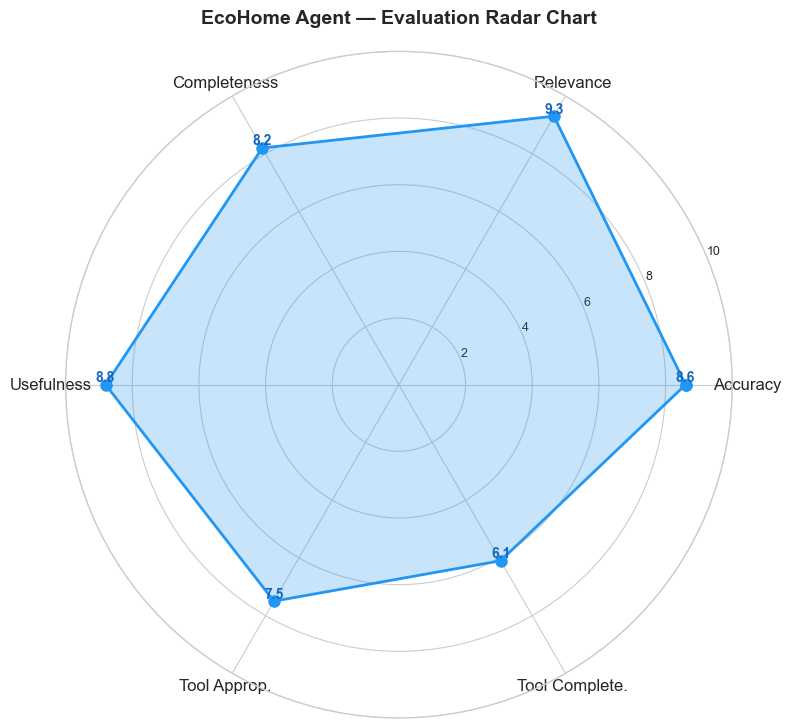

Saved: data/evaluation_radar_chart.png


In [19]:
# Visualization 1: Evaluation Radar Chart
dimensions = ["Accuracy", "Relevance", "Completeness", "Usefulness"]
scores = [report["summary"]["response_scores"][d.lower()] for d in dimensions]

# Add tool scores as extra dimensions
dimensions_ext = dimensions + ["Tool Approp.", "Tool Complete."]
scores_ext = scores + [
    report["summary"]["tool_appropriateness"] * 10,
    report["summary"]["tool_completeness"] * 10,
]

angles = np.linspace(0, 2 * np.pi, len(dimensions_ext), endpoint=False).tolist()
scores_plot = scores_ext + [scores_ext[0]]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.fill(angles, scores_plot, color="#2196F3", alpha=0.25)
ax.plot(angles, scores_plot, color="#2196F3", linewidth=2, marker="o", markersize=8)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(dimensions_ext, fontsize=12)
ax.set_ylim(0, 10)
ax.set_yticks([2, 4, 6, 8, 10])
ax.set_yticklabels(["2", "4", "6", "8", "10"], fontsize=9)
ax.set_title(
    "EcoHome Agent — Evaluation Radar Chart", fontsize=14, fontweight="bold", pad=20
)

# Add score labels
for angle, score, label in zip(angles[:-1], scores_ext, dimensions_ext):
    ax.annotate(
        f"{score:.1f}",
        xy=(angle, score),
        fontsize=10,
        fontweight="bold",
        ha="center",
        va="bottom",
        color="#1565C0",
    )

plt.tight_layout()
plt.savefig("data/evaluation_radar_chart.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: data/evaluation_radar_chart.png")

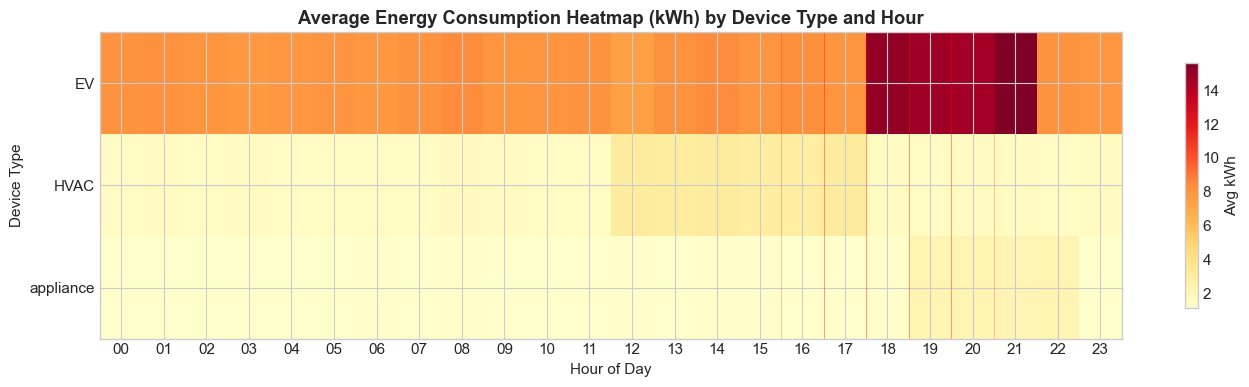

Saved: data/energy_usage_heatmap.png


In [20]:
# Visualization 2: Energy Usage Heatmap by Device Type and Hour
conn = sqlite3.connect("data/energy_data.db")
df_usage = pd.read_sql_query("SELECT * FROM energy_usage", conn)
conn.close()

df_usage["timestamp"] = pd.to_datetime(df_usage["timestamp"])
df_usage["hour"] = df_usage["timestamp"].dt.hour

# Pivot table: average consumption by device type and hour
pivot = df_usage.pivot_table(
    values="consumption_kwh", index="device_type", columns="hour", aggfunc="mean"
)

fig, ax = plt.subplots(figsize=(14, 4))
im = ax.imshow(pivot.values, aspect="auto", cmap="YlOrRd", interpolation="nearest")
ax.set_xticks(range(24))
ax.set_xticklabels([f"{h:02d}" for h in range(24)])
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels(pivot.index)
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Device Type")
ax.set_title(
    "Average Energy Consumption Heatmap (kWh) by Device Type and Hour",
    fontweight="bold",
)

# Add peak pricing overlay
for h in range(16, 21):
    ax.axvline(x=h - 0.5, color="red", linewidth=0.5, alpha=0.3)
    ax.axvline(x=h + 0.5, color="red", linewidth=0.5, alpha=0.3)

cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label("Avg kWh")
plt.tight_layout()
plt.savefig("data/energy_usage_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: data/energy_usage_heatmap.png")

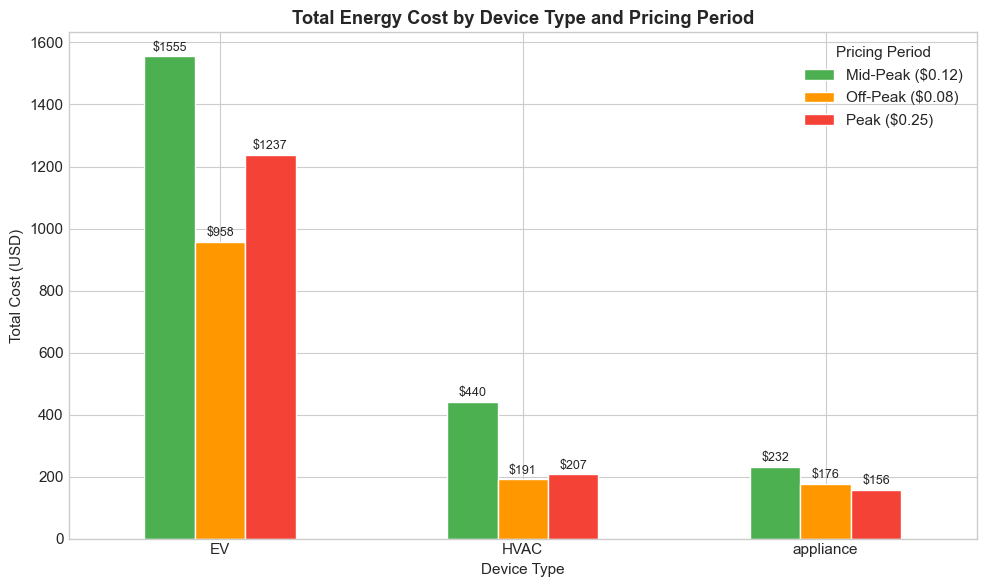

Saved: data/cost_optimization_chart.png

✅ All visualizations generated successfully!


In [21]:
# Visualization 3: Cost Optimization — Peak vs Off-Peak Savings Potential
# Calculate average cost per device during peak vs off-peak hours
df_usage["is_peak"] = df_usage["hour"].apply(
    lambda h: (
        "Peak ($0.25)"
        if 16 <= h < 21
        else ("Off-Peak ($0.08)" if (h >= 22 or h < 6) else "Mid-Peak ($0.12)")
    )
)

cost_by_period = (
    df_usage.groupby(["device_type", "is_peak"])["cost_usd"].sum().unstack(fill_value=0)
)

fig, ax = plt.subplots(figsize=(10, 6))
cost_by_period.plot(
    kind="bar", ax=ax, color=["#4CAF50", "#FF9800", "#F44336"], edgecolor="white"
)
ax.set_title("Total Energy Cost by Device Type and Pricing Period", fontweight="bold")
ax.set_xlabel("Device Type")
ax.set_ylabel("Total Cost (USD)")
ax.legend(title="Pricing Period")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Add savings annotation
for container in ax.containers:
    ax.bar_label(container, fmt="$%.0f", fontsize=9, padding=2)

plt.tight_layout()
plt.savefig("data/cost_optimization_chart.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: data/cost_optimization_chart.png")

print("\n✅ All visualizations generated successfully!")